<a href="https://colab.research.google.com/github/KimYongHwi/ml-perfect-guide-study/blob/main/6_3%EC%9E%A5_%EB%B0%B0%EA%B9%85(Bagging)_%EB%9E%9C%EB%8D%A4%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8(RandomForest).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 배깅(Bagging) - 랜덤포레스트(RandomForest)

- Bagging의 대표적인 알고리즘은 랜덤 포레스트이다.
- RandomForest는 다재 다능한 알고리즘으로 앙상블 알고리즘 중 비교적 빠른 수행 속도를 가지고 있으며, 다양한 영역에서 높은 예측 성능을 보이고 있다.
- RandomForest는 여러개의 결정 트리 분류기가 전체 데이터에서 Bagging 방식으로 각자의 데이터를 샘플링해 개별적으로 학습을 수행한 뒤 최종적으로 모든 분류기가 Voting을 통해 예측 결정을 하게 된다.

### RandomForest의 부트스트래핑 분할

- RandomForest는 개별적인 분류기의 기반 알고리즘은 결정 트리이지만 개별 트리가 학습하는 데이터 세트는 전체 데이터에서 일부가 중첩되게 샘플링된 데이터 세트이다. 이렇게 여러 개의 데이터 세트를 중첩되게 분리하는 것을 부트스트래핑(bootstrapping) 분할 방식이라고 한다. (Bagging은 bootstrap aggregating이 줄임말이다.)

### 사이킷런 RandomForest 하이퍼 파파미터

- n_estimators: RandomForest의 결정 트리 개수를 지정한다. 기본값은 10이다.
- max_features는 결정 트리에 사용된 max_features와 동일한 파라미터이고 기본값은 `sqrt(제곱근)`로 트리를 분할 하는 피처를 참조할 때 전체 피처가 아니라 sqrt(전체 피처 개수)만큼 참조한다.
- max_depth나 min_samples_leaf와 같이 결정 트리에서 과적합을 개선하기 위해 사용되는 파라미터가 RandomForest에도 똑같이 적용될 수 있다.

In [2]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
from pathlib import Path

In [4]:
folder = "ml_definitive_guide/data/human_activity_dataset"

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder
os.chdir(project_path)

for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])

print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive/ml_definitive_guide/data/human_activity_dataset


In [5]:
import pandas as pd

# features.txt 파일에 있는 컬럼명을 입력 받아서 중복된 컬럼명은 
# 원본 컬럼명+_1, _2와 같이 중복된 차수를 원본 컬럼명에 더해서 컬럼명을 update 하는 함수
def get_new_feature_name_df(old_feature_name_df):
    #column_name으로 중복된 컬럼명에 대해서는 중복 차수 부여, col1, col1과 같이 2개의 중복 컬럼이 있을 경우 1, 2 
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])

    # feature_dup_df의 index인 column_name을 reset_index()를 이용하여 컬럼으로 변환. 
    feature_dup_df = feature_dup_df.reset_index()

    # 인자로 받은 features_txt의 컬럼명 DataFrame과 feature_dup_df를 조인. 
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')

    # 새로운 컬럼명은 앞에 중복 차수를 접미어로 결합. 
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv(
        './features.txt', 
        sep='\s+', header=None, names=['column_index', 'column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

**학습/테스트 데이터로 분리하고 RandomRorest로 학습/예측/평가**

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤포레스트 정확도: {0:.4f}'.format(accuracy))


랜덤포레스트 정확도: 0.9253


In [7]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 200, 300],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


**튜닝된 하이퍼 파라미터로 재 학습 및 예측/평가**

In [8]:
rf_clf = RandomForestClassifier(**grid_cv.best_params_)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤포레스트 정확도: 0.9189


**개별 feature들의 중요도 시각화**

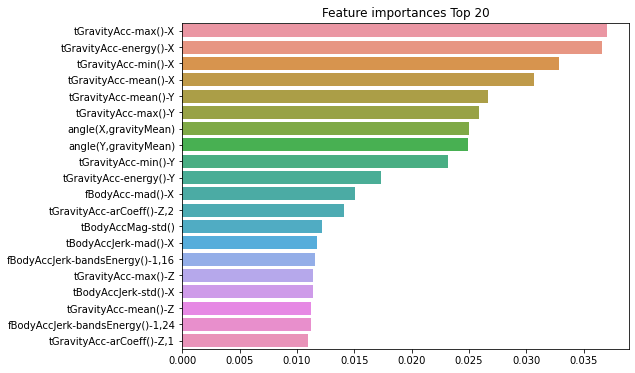

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()